In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from skimage.io import imread

import nibabel as nib

In [3]:
train_dir = "./Dataset/Training/Data"

file_list = os.listdir("./Dataset/Training/Data")
nii_files = [os.path.join(train_dir, file) for file in file_list if file.endswith(".nii")]
glm_files = [file for file in nii_files if file.endswith("glm.nii")]
for glm in glm_files:
    nii_files.remove(glm)

In [4]:
nib.Nifti1Header.quaternion_threshold = -1e-06  # https://github.com/nipy/nibabel/issues/626
img = np.array(nib.load(nii_files[0]).dataobj).astype(np.float64)

### padding
img = np.pad(img, ((14,14),(14,14),(14,14)),'constant', constant_values=(0))

print(img.shape)

i,j,k =100,100,100
# center (14,14)
print(img[i-14:i+15, j-14:j+15, k].shape)
print(img[i, j-14:j+15, k-14:k+15].shape)
print(img[i-14:i+15, j, k-14:k+15].shape)

(284, 284, 347)
(29, 29)
(29, 29)
(29, 29)


In [5]:
data_dir = "./Dataset/Training/Data"
# data_file = "1000_3.nii"
data_file = None

if data_file is None and data_dir:
    file_list = os.listdir(data_dir)
    nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii")]
    glm_files = [file for file in nii_files if file.endswith("glm.nii")]
    for glm in glm_files:
        nii_files.remove(glm)

elif isinstance(data_file, str):
    nii_files = [os.path.join(data_dir, data_file)]
    glm_files = [nii_files[0].split(".n")[0] + "_glm.nii"]


### settings for nibabel ###
nib.Nifti1Header.quaternion_threshold = -1e-06
data_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in nii_files]

len(data_list)

15

# GET X, Y data

In [8]:
data_dir = "./Dataset/Training/Data"
# data_file = "1000_3.nii"
data_file = None

if data_file is None and data_dir:
    file_list = os.listdir(data_dir)
    nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii") and not file.endswith("glm.nii")]
    glm_files = []
    for nii in nii_files:
        directory, file = os.path.split(nii)
        glm_files.append(os.path.join(directory, file.split(".")[0]+"_glm.nii"))

elif isinstance(data_file, str):
    nii_files = [os.path.join(data_dir, data_file)]
    glm_files = [nii_files[0].split(".n")[0] + "_glm.nii"]


### settings for nibabel ###
nib.Nifti1Header.quaternion_threshold = -1e-06

print(nii_files)
print(glm_files)

data_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in nii_files]
label_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in glm_files]

print(len(data_list))

['./Dataset/Training/Data/1015_3.nii', './Dataset/Training/Data/1017_3.nii', './Dataset/Training/Data/1013_3.nii', './Dataset/Training/Data/1011_3.nii', './Dataset/Training/Data/1008_3.nii', './Dataset/Training/Data/1014_3.nii', './Dataset/Training/Data/1010_3.nii', './Dataset/Training/Data/1009_3.nii', './Dataset/Training/Data/1036_3.nii', './Dataset/Training/Data/1012_3.nii', './Dataset/Training/Data/1007_3.nii', './Dataset/Training/Data/1001_3.nii', './Dataset/Training/Data/1006_3.nii', './Dataset/Training/Data/1002_3.nii', './Dataset/Training/Data/1000_3.nii']
['./Dataset/Training/Data/1015_3_glm.nii', './Dataset/Training/Data/1017_3_glm.nii', './Dataset/Training/Data/1013_3_glm.nii', './Dataset/Training/Data/1011_3_glm.nii', './Dataset/Training/Data/1008_3_glm.nii', './Dataset/Training/Data/1014_3_glm.nii', './Dataset/Training/Data/1010_3_glm.nii', './Dataset/Training/Data/1009_3_glm.nii', './Dataset/Training/Data/1036_3_glm.nii', './Dataset/Training/Data/1012_3_glm.nii', './Datas

In [9]:
print(data_list[0].shape)
print(label_list[0].shape)

(256, 256, 319)
(256, 256, 319)


# CENTROID

In [10]:
class RegionCentroids():
    def __init__(self, n_regions):
        self.n_regions = n_regions
        self.barycentres = np.zeros((n_regions, 3))

    def update_barycentres(self, vxs, regions):
        self.barycentres = np.zeros((self.n_regions, 3))
        for i in range(self.n_regions):
            idxs = regions == i
            if vxs[idxs].size == 0:
                continue
            self.barycentres[i] = (np.mean(vxs[idxs], axis=0))

        # For zero values (with no regions present), set them to the mean
        self.barycentres[self.barycentres == 0] = self.barycentres[self.barycentres != 0].mean()

    def compute_scaled_distances(self, vx):
        distances = np.linalg.norm(self.barycentres - vx, axis=1)
        return distances

In [11]:
x = data_list[0]
y = label_list[0]

region_centroids = RegionCentroids(208) # parameter로 전체 label + 1개 전달
temp = y.nonzero()
print(temp)
vxs = np.asarray(temp).T
region_centroids.update_barycentres(vxs, y[temp])

(array([ 50,  50,  50, ..., 180, 180, 180]), array([126, 126, 126, ..., 124, 124, 124]), array([125, 126, 127, ..., 117, 119, 121]))


# GET DATA FOR SINGLE BRAIN

In [12]:
x = data_list[0]
y = label_list[0]


# get centroid object

def get_centroid_obj(y):
    label_list = np.unique(y)
    centroid_obj = RegionCentroids(int(label_list.max())+1) # parameter로 전체 label + 1개 전달
    temp = y.nonzero()
    vxs = np.asarray(temp).T
    centroid_obj.update_barycentres(vxs, y[temp])
    return centroid_obj

# get patches
def get_patches(x):
    patches = []
    x_shape = x.shape
    for i in range(x_shape[0]):
        for j in range(x_shape[1]):
            for k in range(x_shape[2]):
                if y[i][j][k] == 0:
                    pass
                else:
                    patches.append(
                        {
                            "y_index" : [i,j,k],
                            "3d_patch_scale_1" : x[i-14:i+15, j-14:j+15, k-14:k+15],
                            "3d_patch_scale_3" : x[i-43:i+44, j-43:j+44, k-43:k+44],
                        }
                    )
    return patches

single_brain_data = {
    "x" : x,
    "y" : y,
    "patch" : get_patches(x),
    "centroid" : get_centroid_obj(y),
}
                
# patch_x_scale_1 => 3d_patch_scale_1[14]
# patch_y_scale_1 => 3d_patch_scale_1[:, 14]
# patch_z_scale_1 => 3d_patch_scale_1[:,:,14]

# patch_x_scale_3 => 3d_patch_scale_3[43]
# patch_y_scale_3 => 3d_patch_scale_3[:, 43]
# patch_z_scale_3 => 3d_patch_scale_3[:, :, 43]

In [14]:
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14][14][14])
print(single_brain_data["patch"][0]["3d_patch_scale_1"].shape)

574.0
(29, 29, 29)


574.0
574.0


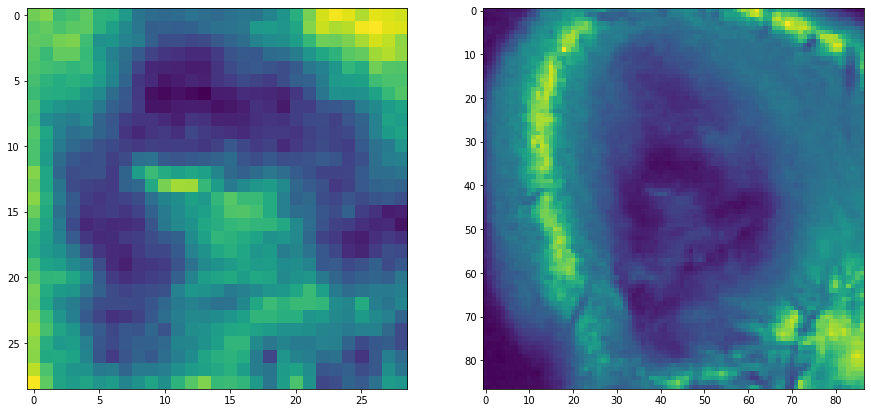

In [15]:
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14][14][14])
print(single_brain_data["patch"][0]["3d_patch_scale_3"][43][43][43])

f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][43])

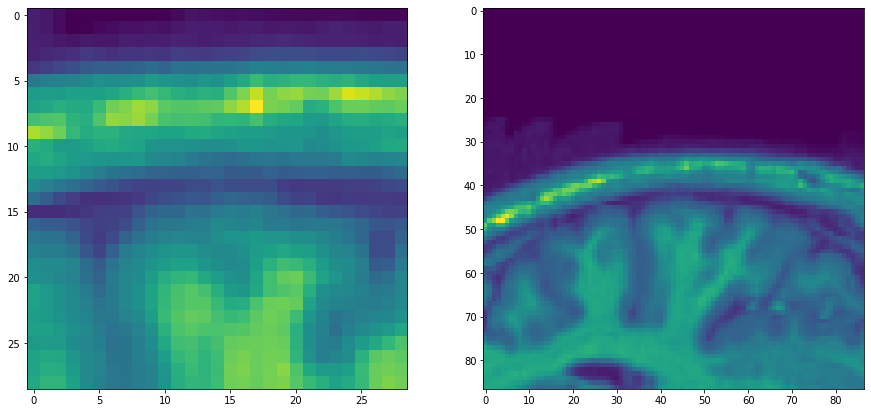

In [16]:
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][:, 14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, 43])

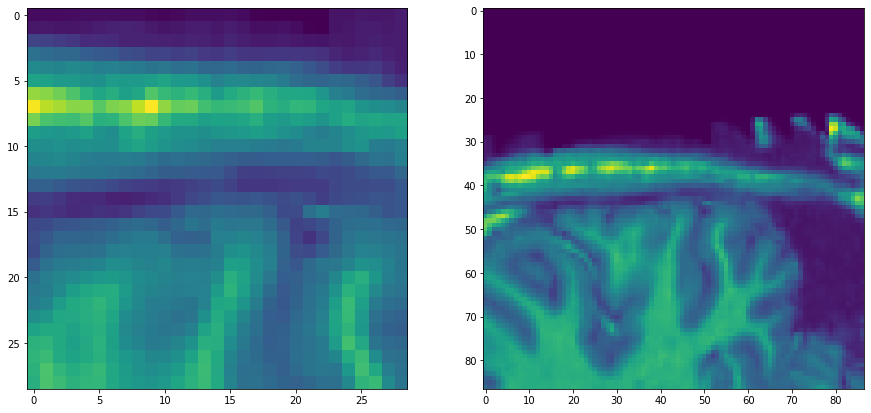

In [17]:
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][:, :, 14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, :, 43])

# TORCH DATASET

In [7]:
class BrainSegmentationDataset(Dataset):

    def __init__(self, data_dir, data_file=None, transform=None):
        
        if data_file is None and data_dir:
            file_list = os.listdir(data_dir)
            nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii")]
            glm_files = [file for file in nii_files if file.endswith("glm.nii")]
            for glm in glm_files:
                nii_files.remove(glm)

        elif isinstance(data_file, str):
            nii_files = [os.path.join(data_dir, data_file)]
            glm_files = [nii_file.split(".n")[0] + "_glm.nii"]
            
        
        ### settings for nibabel ###
        nib.Nifti1Header.quaternion_threshold = -1e-06
        
        self.data_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in nii_files]
        
        

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample